IMPORT ALL THE LIBRARIES

In [1]:
# importing all the libraries
# Standard Python libraries:
import sys
import time
from typing import List, Dict, Any, Union
import warnings

# Third-party libraries:
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import (
    Pipeline as imbpipeline, 
    make_pipeline as make_imbpipeline,
)
import joblib
import matplotlib.pyplot as plt
from nptyping import NDArray
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (
    confusion_matrix, 
    ConfusionMatrixDisplay, 
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score,
    roc_auc_score,
    roc_curve,
    average_precision_score,
    PrecisionRecallDisplay,
)
from sklearn.model_selection import (
    train_test_split, 
    RepeatedStratifiedKFold, 
    cross_validate, 
    GridSearchCV,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

# Settings:
warnings.filterwarnings("ignore")
np.set_printoptions(threshold=sys.maxsize)
pd.set_option("display.max_colwidth", None)
sns.set_theme()

Read the Dataset

In [2]:
#importing and reading the dataset

stroke_df= pd.read_csv("healthcare-dataset-stroke-data.csv")

In [4]:
stroke_df.columns = stroke_df.columns.str.lower()
stroke_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [5]:
stroke_df.head()

id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   

       work_type residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   
3        Private          Urban             171.23  34.4           smokes   
4  Self-employed          Rural             174.12  24.0     never smoked   

   stroke  
0       1  
1       1  
2       1  
3       1  
4       1

ID Features

In [13]:
df = stroke_df.drop_duplicates(subset="id")
df = df.drop(["id"], axis=1)

Gender

In [14]:
df["gender"].value_counts()

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

In [15]:

df["gender"] = df["gender"].replace(["Other"], "Female")
gender_conversion = {"Male": 0, "Female": 1}
df["gender"] = df["gender"].map(gender_conversion)
df["gender"] = df["gender"].astype(int)

In [16]:
plt.figure(figsize=(6,4))
sns.barplot(x="gender", y="stroke", data=df)
plt.xticks(list(gender_conversion.values()), list(gender_conversion.keys()))
plt.xlabel("\nGender", fontweight="bold")
plt.ylabel("Stroke (mean)\n", fontweight="bold")
plt.show()

Age Feature

In [17]:
df["age"].describe()

count    5110.000000
mean       43.226614
std        22.612647
min         0.080000
25%        25.000000
50%        45.000000
75%        61.000000
max        82.000000
Name: age, dtype: float64

In [18]:
plt.figure(figsize=(10,6))
sns.histplot(
    df[df["stroke"] == 0]["age"], 
    binwidth=5, 
    binrange=[0, 85], 
    stat="probability", 
    color="limegreen", 
    label="No stroke",
)
sns.histplot(
    df[df["stroke"] == 1]["age"], 
    binwidth=5, 
    binrange=[0, 85], 
    stat="probability", 
    color="firebrick", 
    label="Stroke",
)
plt.xlabel("\nAge", fontweight="bold")
plt.ylabel("Stroke (probability)\n", fontweight="bold")
plt.legend()
plt.show()

Hypertension Feature

In [19]:
df["hypertension"].value_counts()

0    4612
1     498
Name: hypertension, dtype: int64

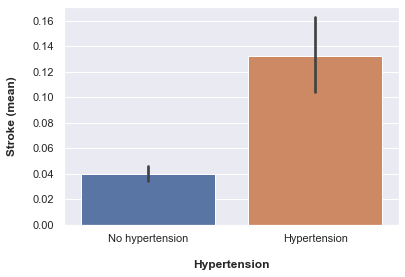

In [20]:
hypertension_conversion = {"No hypertension": 0, "Hypertension": 1}
plt.figure(figsize=(6,4))
sns.barplot(x="hypertension", y="stroke", data=df)
plt.xticks(list(hypertension_conversion.values()), list(hypertension_conversion.keys()))
plt.xlabel("\nHypertension", fontweight="bold")
plt.ylabel("Stroke (mean)\n", fontweight="bold")
plt.show()

Heart Disease Feature

In [22]:
df["heart_disease"].value_counts()

0    4834
1     276
Name: heart_disease, dtype: int64

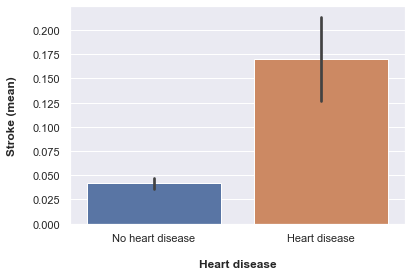

In [23]:
heart_conversion = {"No heart disease": 0, "Heart disease": 1}
plt.figure(figsize=(6,4))
sns.barplot(x="heart_disease", y="stroke", data=df)
plt.xticks(list(heart_conversion.values()), list(heart_conversion.keys()))
plt.xlabel("\nHeart disease", fontweight="bold")
plt.ylabel("Stroke (mean)\n", fontweight="bold")
plt.show()

Marital Feature

In [24]:
df["ever_married"].value_counts()

Yes    3353
No     1757
Name: ever_married, dtype: int64

In [25]:
married_conversion = {"No": 0, "Yes": 1}
df["ever_married"] = df["ever_married"].map(married_conversion)
df["ever_married"] = df["ever_married"].astype(int)

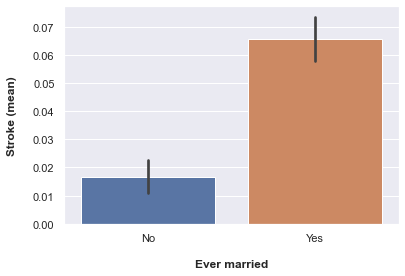

In [26]:
plt.figure(figsize=(6,4))
sns.barplot(x="ever_married", y="stroke", data=df)
plt.xticks(list(married_conversion.values()), list(married_conversion.keys()))
plt.xlabel("\nEver married", fontweight="bold")
plt.ylabel("Stroke (mean)\n", fontweight="bold")
plt.show()

Work Type Feature

In [27]:
plt.figure(figsize=(10,6))
sns.barplot(x="work_type", y="stroke", data=df)
plt.xlabel("\nWork type", fontweight="bold")
plt.ylabel("Stroke (mean)\n", fontweight="bold")
plt.show()

In [28]:
df["work_type"] = df["work_type"].replace(["Self-employed"], "self-employed")
df["work_type"] = df["work_type"].replace(["Private", "Govt_job"], "employed")
df["work_type"] = df["work_type"].replace(["children", "Never_worked"], "never_employed")

# Sanity check that children (up to age 12) are never employed:
df.loc[df["age"] < 13, "work_type"] = "never_employed"

df["work_type"].value_counts()

employed          3581
self-employed      818
never_employed     711
Name: work_type, dtype: int64

Since the work type categories are nominal, we can benefit from one-hot encoding (we will drop one column to remove redundant information) to create a numerical variable:

In [29]:
df_work_ohe = pd.get_dummies(
    df["work_type"], 
    prefix="work_ohe", 
    drop_first=True,
)
df = pd.concat([df, df_work_ohe], axis=1)
df = df.drop(["work_type"], axis=1)

Residence Type

In [30]:
df["residence_type"].value_counts()

Urban    2596
Rural    2514
Name: residence_type, dtype: int64

In [31]:
residence_conversion = {"Rural": 0, "Urban": 1}
df["residence_type"] = df["residence_type"].map(residence_conversion)
df["residence_type"] = df["residence_type"].astype(int)

In [32]:
plt.figure(figsize=(6,4))
sns.barplot(x="residence_type", y="stroke", data=df)
plt.xticks(list(residence_conversion.values()), list(residence_conversion.keys()))
plt.xlabel("\nResidence type", fontweight="bold")
plt.ylabel("Stroke (mean)\n", fontweight="bold")
plt.show()

Glucose Level

In [33]:
df["avg_glucose_level"].describe()

count    5110.000000
mean      106.147677
std        45.283560
min        55.120000
25%        77.245000
50%        91.885000
75%       114.090000
max       271.740000
Name: avg_glucose_level, dtype: float64

    A blood sugar level less than 140 mg/dL is normal. A reading of more than 200 mg/dL after two hours indicates diabetes. A reading between 140 and 199 mg/dL indicates prediabetes.

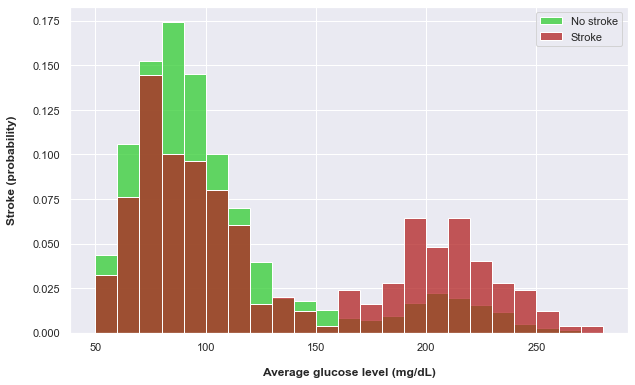

In [34]:
plt.figure(figsize=(10,6))
sns.histplot(
    df[df["stroke"] == 0]["avg_glucose_level"], 
    binwidth=10, 
    binrange=[50, 280], 
    stat="probability", 
    color="limegreen", 
    label="No stroke",
)
sns.histplot(
    df[df["stroke"] == 1]["avg_glucose_level"], 
    binwidth=10, 
    binrange=[50, 280], 
    stat="probability", 
    color="firebrick", 
    label="Stroke",
)
plt.xlabel("\nAverage glucose level (mg/dL)", fontweight="bold")
plt.ylabel("Stroke (probability)\n", fontweight="bold")
plt.legend()
plt.show()

Smoking Status

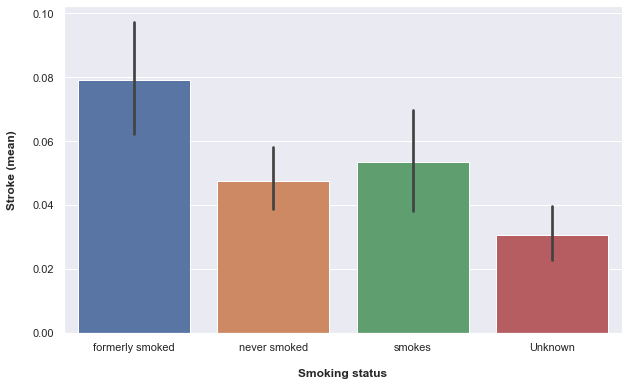

In [35]:
plt.figure(figsize=(10,6))
sns.barplot(x="smoking_status", y="stroke", data=df)
plt.xlabel("\nSmoking status", fontweight="bold")
plt.ylabel("Stroke (mean)\n", fontweight="bold")
plt.show()

In [36]:
df["smoking_status"].value_counts()

never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64

In [37]:
df_smoking_ohe = pd.get_dummies(
    df["smoking_status"], 
    prefix="smoking_ohe", 
    drop_first=True,
)
df_smoking_ohe = df_smoking_ohe.rename(columns={
    "smoking_ohe_never smoked": "smoking_ohe_never_smoked", 
    "smoking_ohe_formerly smoked": "smoking_ohe_formerly_smoked",
})
df = pd.concat([df, df_smoking_ohe], axis=1)
df = df.drop(["smoking_status"], axis=1)

BMI

In [38]:
df["bmi"].describe()

count    4909.000000
mean       28.893237
std         7.854067
min        10.300000
25%        23.500000
50%        28.100000
75%        33.100000
max        97.600000
Name: bmi, dtype: float64

            BMI	Weight status
            < 18.5	Underweight
            18.5 - 24.9	Normal weight
            25.0 - 29.9	Overweight
            > 30.0	Obese
From earlier we know that there are 201 missing values for this field. There are various ways to deal with this. The best option might be to infer those missing values from the other features using a regression model. For convenience, let us pick the easiest regression algorithm for this, i.e. linear regression:

In [39]:
train_data = df.dropna()
X_train = train_data.drop("bmi", axis=1)
y_train = train_data["bmi"]

test_data = df[df["bmi"].isnull()]
X_test = test_data.drop("bmi", axis=1)

model = LinearRegression()
model.fit(X_train, y_train)
y_test = model.predict(X_test)

bmi_slice = df["bmi"].copy()
bmi_slice[np.isnan(bmi_slice)] = y_test
df["bmi"] = bmi_slice

Relationship of BMI with Stroke

In [40]:
plt.figure(figsize=(10,6))
sns.histplot(
    df[df["stroke"] == 0]["bmi"], 
    binwidth=2, 
    binrange=[10, 100], 
    stat="probability", 
    color="limegreen", 
    label="No stroke",
)
sns.histplot(
    df[df["stroke"] == 1]["bmi"], 
    binwidth=2, 
    binrange=[10, 100], 
    stat="probability", 
    color="firebrick", 
    label="Stroke",
)
plt.xlabel("\nBMI (kg/m2)", fontweight="bold")
plt.ylabel("Stroke (probability)\n", fontweight="bold")
plt.legend()
plt.show()

Stroke lebel

In [41]:
df["stroke"].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

0    95.1%
1     4.9%
Name: stroke, dtype: object

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5110 entries, 0 to 5109
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   gender                       5110 non-null   int32  
 1   age                          5110 non-null   float64
 2   hypertension                 5110 non-null   int64  
 3   heart_disease                5110 non-null   int64  
 4   ever_married                 5110 non-null   int32  
 5   residence_type               5110 non-null   int32  
 6   avg_glucose_level            5110 non-null   float64
 7   bmi                          5110 non-null   float64
 8   stroke                       5110 non-null   int64  
 9   work_ohe_never_employed      5110 non-null   uint8  
 10  work_ohe_self-employed       5110 non-null   uint8  
 11  smoking_ohe_formerly_smoked  5110 non-null   uint8  
 12  smoking_ohe_never_smoked     5110 non-null   uint8  
 13  smoking_ohe_smokes

In [43]:
df.head()

gender   age  hypertension  heart_disease  ever_married  residence_type  \
0       0  67.0             0              1             1               1   
1       1  61.0             0              0             1               0   
2       0  80.0             0              1             1               0   
3       1  49.0             0              0             1               1   
4       1  79.0             1              0             1               0   

   avg_glucose_level        bmi  stroke  work_ohe_never_employed  \
0             228.69  36.600000       1                        0   
1             202.21  31.158272       1                        0   
2             105.92  32.500000       1                        0   
3             171.23  34.400000       1                        0   
4             174.12  24.000000       1                        0   

   work_ohe_self-employed  smoking_ohe_formerly_smoked  \
0                       0                            1   
1                       1                            0   
2                       0                            0   
3                       0                            0   
4                       1                            0   

   smoking_ohe_never_smoked  smoking_ohe_smokes  
0                         0                   0  
1                         1                   0  
2                         1                   0  
3                         0                   1  
4                         1                   0

Train - Test Split

In [44]:
X = df.drop(["stroke"], axis=1)
y = df["stroke"]
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    stratify=y, 
    random_state=0,
)

Distribution of the Target Level

In [45]:
print("Distribution of labels in y_train:")
print(y_train.value_counts(normalize=True))

print("\nDistribution of labels in y_test:")
print(y_test.value_counts(normalize=True))

Distribution of labels in y_train:
0    0.951321
1    0.048679
Name: stroke, dtype: float64

Distribution of labels in y_test:
0    0.951076
1    0.048924
Name: stroke, dtype: float64


In [46]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Dimension of the Data

In [62]:
y_train = np.array(y_train)
print("Dimensions of the training set:\n")
print("Features:\t", X_train.shape, "\nLabels:\t\t", y_train.shape)

y_test = np.array(y_test)
print("\nDimensions of the test set:\n")
print("Features:\t", X_test.shape, "\nLabels:\t\t", y_test.shape)

Dimensions of the training set:

Features:	 (4088, 13) 
Labels:		 (4088,)

Dimensions of the test set:

Features:	 (1022, 13) 
Labels:		 (1022,)


Cross Validation

In [64]:
def cross_validation(
    pipeline: imbpipeline,
    metrics: Dict[str, str],
    X_train, 
    y_train, 
) -> Dict[str, float]:
    
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=0)
    cross_val_scores = cross_validate(
        pipeline, 
        X_train, 
        y_train, 
        cv=cv, 
        scoring=metrics,
    )

    results = {}
    for metric in metrics.keys():
        metric_name = "test_" + metric
        mean_score = round(cross_val_scores[metric_name].mean(), 3)
        results[metric] = mean_score

    return results

Besides K-nearest neighbors (KNN), we would like to try a model based on neural networks, namely a multilayer perceptron (MLP), as well as a tree-based model, namely a random forest (RF)

In [65]:
algorithms = {
    "K-nearest neighbors": KNeighborsClassifier(),
    "Multilayer perceptron": MLPClassifier(random_state=0),
    "Random forest": RandomForestClassifier(random_state=0),
}

Performance Matrix

In [66]:
metrics = {
    "Precision": "precision",
    "Recall": "recall",
    "F1": "f1",
    "Accuracy": "accuracy",
}

Result of Cross Validation

In [68]:
cv_results = []
for name, algorithm in algorithms.items():
    start_time = time.time()
    pipeline = make_imbpipeline(
        SMOTE(sampling_strategy=0.8, random_state=0),
        algorithm,
    )
    results = cross_validation(pipeline, metrics, X_train, y_train)
    elapsed_time = round(time.time() - start_time, 2)
    f1 = results["F1"]
    cv_results.append((name, f1))
    print(
        f"\n{name.upper()}\n"
        f"Duration: \t{elapsed_time} seconds"
        f"\nPerformance: \t{results}"
    )


K-NEAREST NEIGHBORS
Duration: 	1.66 seconds
Performance: 	{'Precision': 0.102, 'Recall': 0.323, 'F1': 0.154, 'Accuracy': 0.828}

MULTILAYER PERCEPTRON
Duration: 	150.36 seconds
Performance: 	{'Precision': 0.119, 'Recall': 0.287, 'F1': 0.167, 'Accuracy': 0.864}

RANDOM FOREST
Duration: 	11.76 seconds
Performance: 	{'Precision': 0.117, 'Recall': 0.134, 'F1': 0.124, 'Accuracy': 0.908}


F1 Score

In [84]:
sorted_cv_results = sorted(cv_results, key=lambda x: x[1], reverse=True)
pd.DataFrame(sorted_cv_results, columns=["Model", "F1-score"])

Model  F1-score
0  Multilayer perceptron     0.167
1    K-nearest neighbors     0.154
2          Random forest     0.124

Performs a grid search for a given algorithm to find the best hyperparameters.
    All parameter combinations are considered. The best parameters are those that 
   maximize the F1-score obtained through (repeated) cross validation.

In [86]:
def grid_search(
    pipeline: imbpipeline,
    parameters: Dict[str, List[Any]],
    X_train, 
    y_train,
) -> Dict[str, Union[float, Dict[str, Any]]]:
    
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=0)
    clf = GridSearchCV(pipeline, parameters, cv=cv, scoring="f1")
    clf.fit(X_train, y_train)
    results = {
        "Pipeline": clf.best_estimator_,
        "Parameters": clf.best_params_,
        "F1-score": round(clf.best_score_, 3),
    }

    return results

In [87]:
knn_parameters = {
    "kneighborsclassifier__n_neighbors": [3, 5, 8, 13],
    "kneighborsclassifier__weights": ["uniform", "distance"],
    "kneighborsclassifier__algorithm": ["ball_tree", "kd_tree", "brute"],
    "kneighborsclassifier__p": [1, 2],
}  # Number of combinations: 4*2*3*2 = 48
mlp_parameters = {
    "mlpclassifier__hidden_layer_sizes": [(8,), (13,), (21,), (8, 8,), (13, 13,), (21, 21,)],
    "mlpclassifier__solver": ["adam", "lbfgs"],
    "mlpclassifier__alpha": [0.0001, 0.001, 0.01, 0.1],
    "mlpclassifier__random_state": [0],
}  # Number of combinations: 6*2*4 = 48
rf_parameters = {
    "randomforestclassifier__criterion": ["gini", "entropy"],
    "randomforestclassifier__max_features": ["auto", 5, 8],
    "randomforestclassifier__max_depth": [5, 8, 13, 21],
    "randomforestclassifier__ccp_alpha": [0.0, 0.0001, 0.001],
    "randomforestclassifier__random_state": [0],
}  # Number of combinations: 2*2*4*3 = 48
brf_parameters = {
    "balancedrandomforestclassifier__criterion": ["gini", "entropy"],
    "balancedrandomforestclassifier__max_features": ["auto", 5, 8],
    "balancedrandomforestclassifier__max_depth": [5, 8, 13, 21],
    "balancedrandomforestclassifier__ccp_alpha": [0.0, 0.0001, 0.001],
    "balancedrandomforestclassifier__random_state": [0],
}  # Number of combinations: 2*2*4*3 = 48

settings = {
    "K-nearest neighbors": (KNeighborsClassifier(), knn_parameters),
    "Multilayer perceptron": (MLPClassifier(), mlp_parameters),
    "Random forest": (RandomForestClassifier(), rf_parameters),
    "Balanced random forest": (BalancedRandomForestClassifier(), brf_parameters),
}

In [89]:
search_results = []
for name, grid in settings.items():
    for strategy in ["(no SMOTE)", "(SMOTE)"]:
        if name.endswith("forest"):
            if strategy == "(SMOTE)":
                continue
            else:
                strategy = ""
        algorithm = grid[0]
        parameters = grid[1]
        
        start_time = time.time()
        if strategy == "(SMOTE)":
            new_name = name + " " + strategy
            pipeline = make_imbpipeline(
                SMOTE(sampling_strategy=0.8, random_state=0),
                algorithm,
            )
        else:
            new_name = name + " " + strategy
            pipeline = make_imbpipeline(algorithm)
        results = grid_search(pipeline, parameters, X_train, y_train)
        elapsed_time = round((time.time() - start_time) / 60, 2)

        best_pipeline = results["Pipeline"]
        best_parameters = results["Parameters"]
        best_f1_score = results["F1-score"]
        search_results.append((
            best_f1_score,
            new_name, 
            best_parameters, 
            best_pipeline, 
        ))
        print(
            f"\n\n{new_name.upper()}\n"
            f"Duration: \t\t{elapsed_time} minutes\n"
            f"Best F1-score: \t\t{best_f1_score}\n"
            f"Hyperparameters: \t{best_parameters}"
        )



K-NEAREST NEIGHBORS (NO SMOTE)
Duration: 		1.14 minutes
Best F1-score: 		0.083
Hyperparameters: 	{'kneighborsclassifier__algorithm': 'ball_tree', 'kneighborsclassifier__n_neighbors': 3, 'kneighborsclassifier__p': 1, 'kneighborsclassifier__weights': 'distance'}


K-NEAREST NEIGHBORS (SMOTE)
Duration: 		1.72 minutes
Best F1-score: 		0.184
Hyperparameters: 	{'kneighborsclassifier__algorithm': 'ball_tree', 'kneighborsclassifier__n_neighbors': 13, 'kneighborsclassifier__p': 1, 'kneighborsclassifier__weights': 'uniform'}


MULTILAYER PERCEPTRON (NO SMOTE)
Duration: 		18.42 minutes
Best F1-score: 		0.145
Hyperparameters: 	{'mlpclassifier__alpha': 0.001, 'mlpclassifier__hidden_layer_sizes': (21,), 'mlpclassifier__random_state': 0, 'mlpclassifier__solver': 'lbfgs'}


MULTILAYER PERCEPTRON (SMOTE)
Duration: 		35.35 minutes
Best F1-score: 		0.222
Hyperparameters: 	{'mlpclassifier__alpha': 0.1, 'mlpclassifier__hidden_layer_sizes': (8,), 'mlpclassifier__random_state': 0, 'mlpclassifier__solver': 

In [90]:
sorted_search_results = sorted(search_results, key=lambda x: x[0], reverse=True)
model_results = pd.DataFrame(
    sorted_search_results, 
    columns=["F1-score", "Model", "Hyperparameters", "Pipeline"],
)
model_results.drop(columns=["Pipeline"], inplace=True)
model_results

F1-score                             Model  \
0     0.228           Balanced random forest    
1     0.222     Multilayer perceptron (SMOTE)   
2     0.184       K-nearest neighbors (SMOTE)   
3     0.145  Multilayer perceptron (no SMOTE)   
4     0.083    K-nearest neighbors (no SMOTE)   
5     0.030                    Random forest    

                                                                                                                                                                                                                                                  Hyperparameters  
0  {'balancedrandomforestclassifier__ccp_alpha': 0.0, 'balancedrandomforestclassifier__criterion': 'gini', 'balancedrandomforestclassifier__max_depth': 21, 'balancedrandomforestclassifier__max_features': 5, 'balancedrandomforestclassifier__random_state': 0}  
1                                                                                                                     {'mlpclassifier__alpha': 0.1, 'mlpclassifier__hidden_layer_sizes': (8,), 'mlpclassifier__random_state': 0, 'mlpclassifier__solver': 'adam'}  
2                                                                                             {'kneighborsclassifier__algorithm': 'ball_tree', 'kneighborsclassifier__n_neighbors': 13, 'kneighborsclassifier__p': 1, 'kneighborsclassifier__weights': 'uniform'}  
3                                                                                                                 {'mlpclassifier__alpha': 0.001, 'mlpclassifier__hidden_layer_sizes': (21,), 'mlpclassifier__random_state': 0, 'mlpclassifier__solver': 'lbfgs'}  
4                                                                                             {'kneighborsclassifier__algorithm': 'ball_tree', 'kneighborsclassifier__n_neighbors': 3, 'kneighborsclassifier__p': 1, 'kneighborsclassifier__weights': 'distance'}  
5                                          {'randomforestclassifier__ccp_alpha': 0.0, 'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': 21, 'randomforestclassifier__max_features': 5, 'randomforestclassifier__random_state': 0}

In [91]:
best_params = sorted_search_results[0][2]
best_params = {param.split("__")[1]: val for param, val in best_params.items()}
best_model = BalancedRandomForestClassifier(**best_params)
best_model.fit(X_train, y_train)
best_model_path = "model_weights_20211221.pkl"
joblib.dump(best_model, best_model_path)

['model_weights_20211221.pkl']

In [92]:
rf = joblib.load(best_model_path)
weights = list(rf.feature_importances_.round(3))
feature_names = list(X.columns)
relevancies = list(zip(feature_names, weights))
sorted_relevancies = sorted(relevancies, key=lambda x: x[1], reverse=True)
pd.DataFrame(sorted_relevancies, columns=["Feature", "Relative importance"])

Feature  Relative importance
0                           age                0.423
1             avg_glucose_level                0.191
2                           bmi                0.165
3                  ever_married                0.034
4                  hypertension                0.029
5        work_ohe_self-employed                0.026
6                 heart_disease                0.023
7                residence_type                0.023
8                        gender                0.022
9      smoking_ohe_never_smoked                0.021
10  smoking_ohe_formerly_smoked                0.016
11           smoking_ohe_smokes                0.016
12      work_ohe_never_employed                0.010

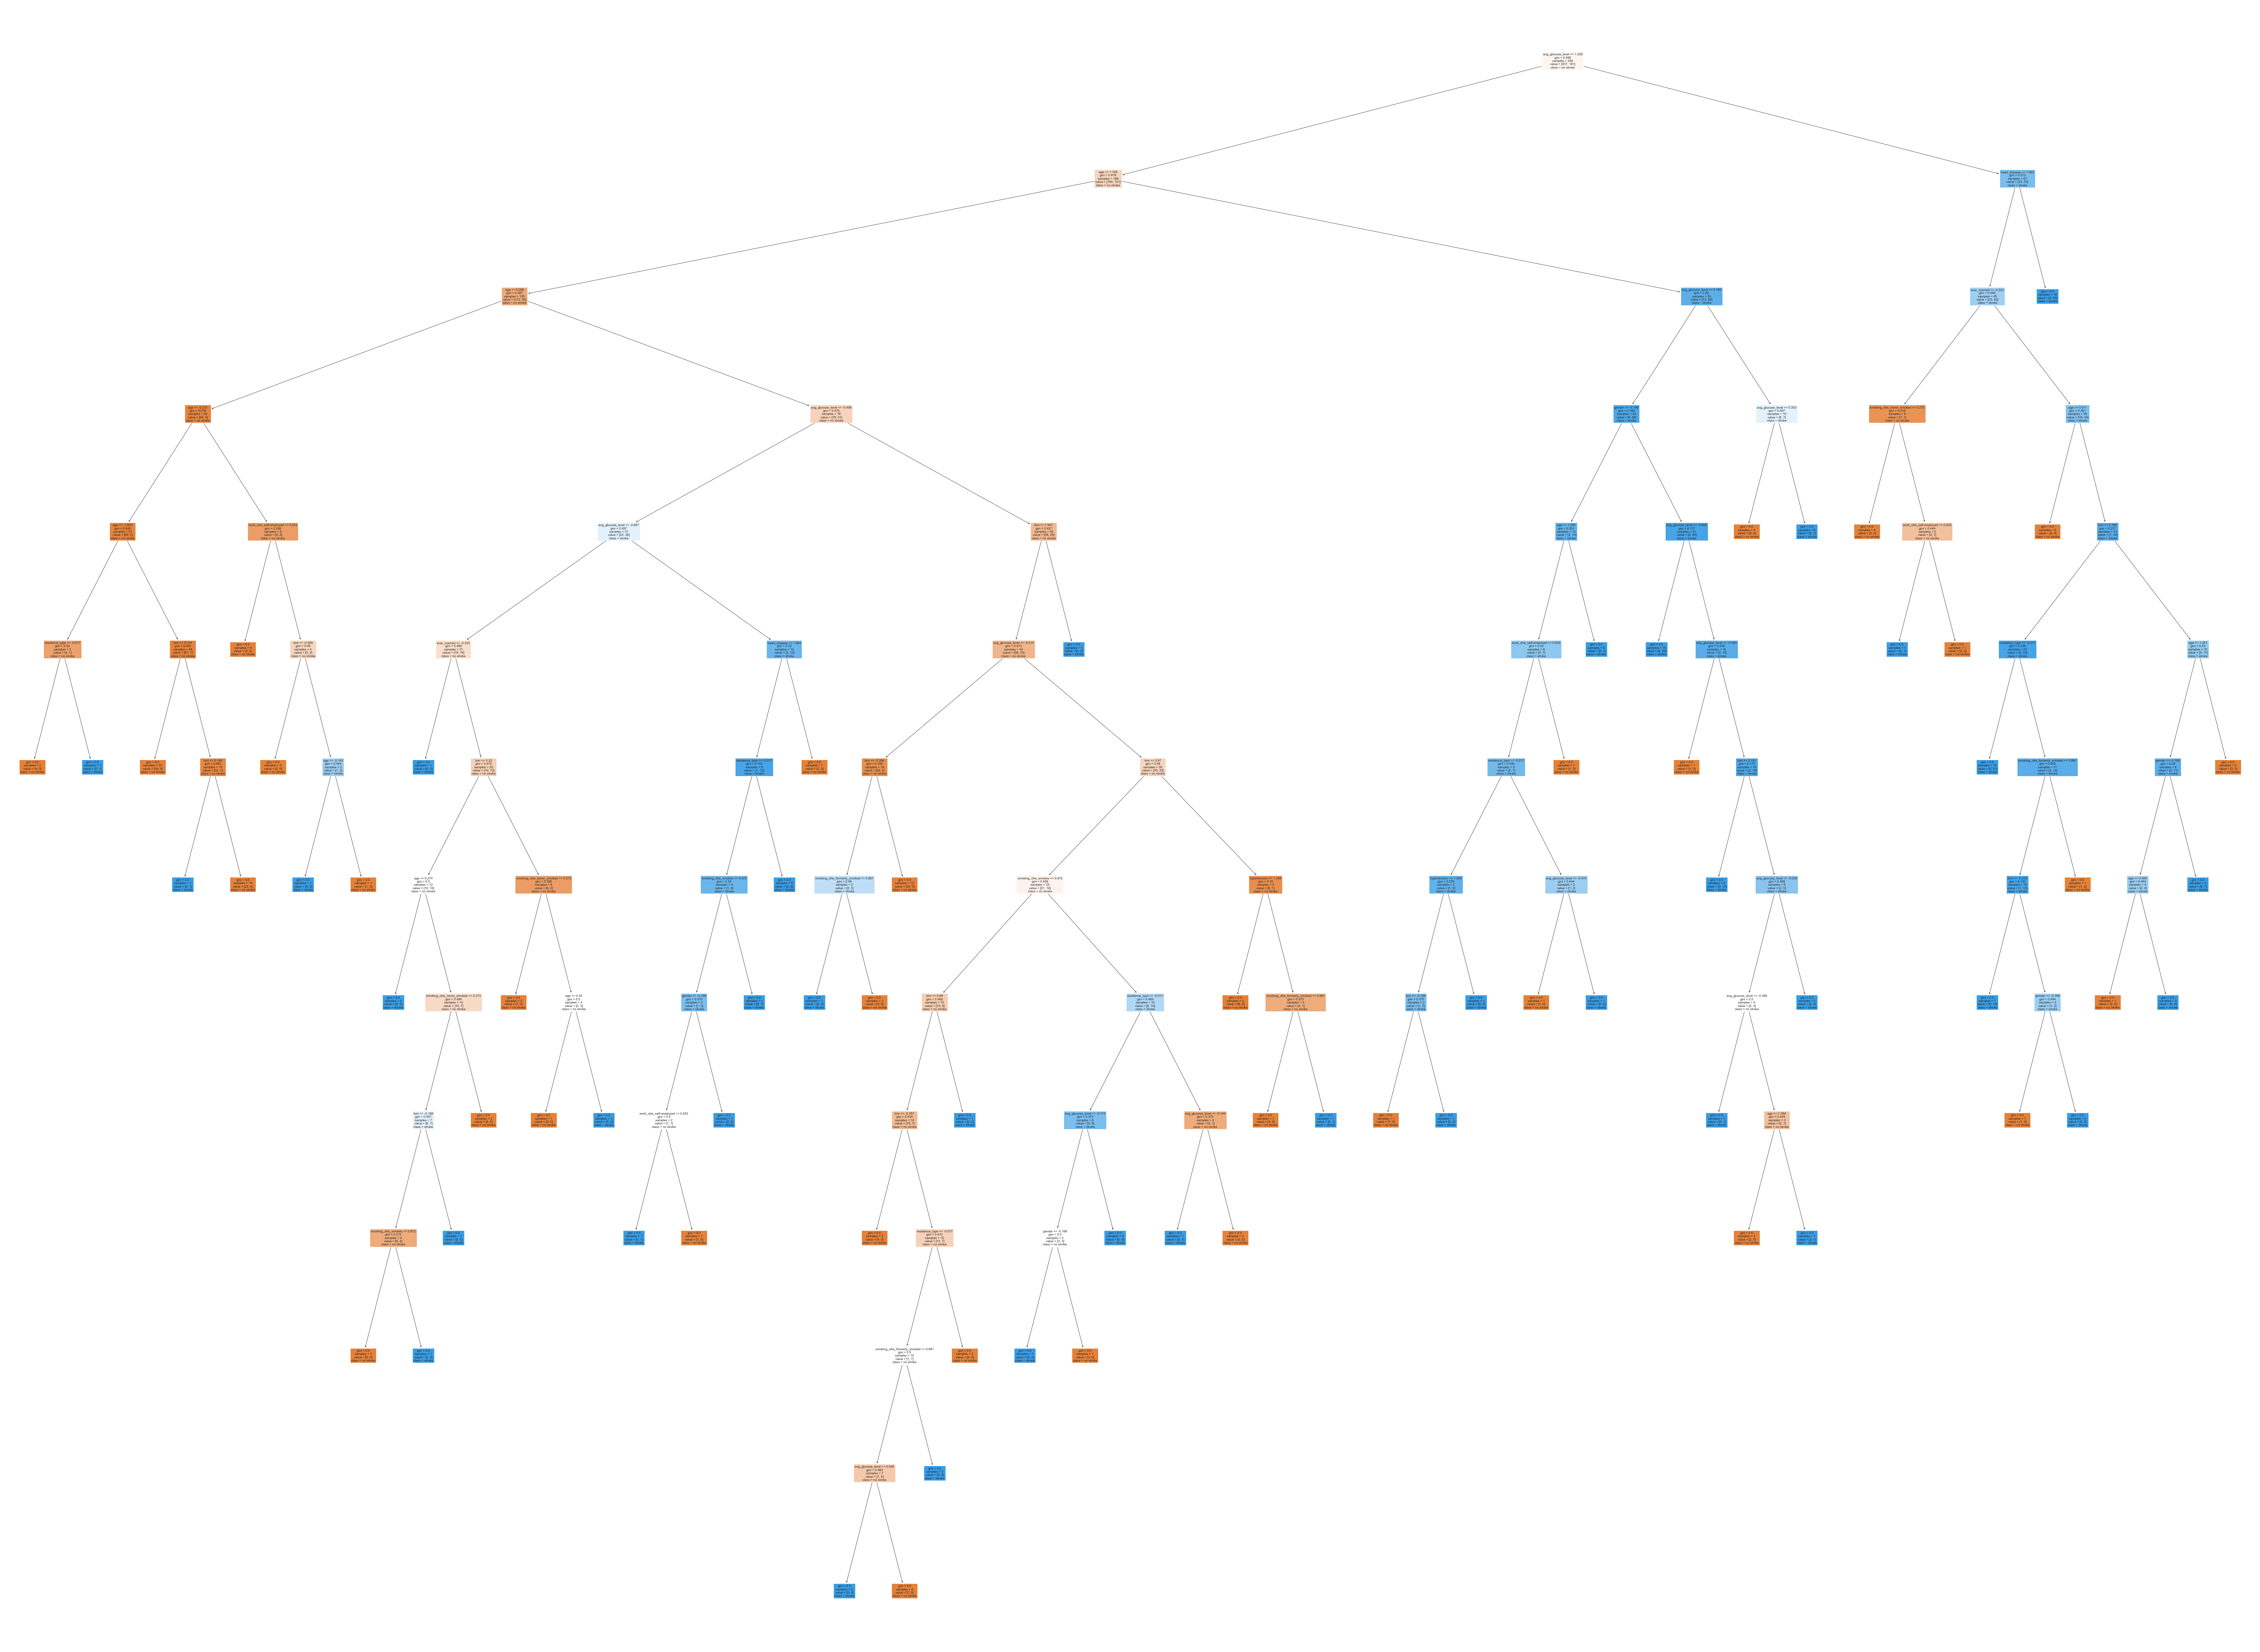

In [93]:
fig = plt.figure(figsize=(128, 96))
tree.plot_tree(
    rf.estimators_[0],
    feature_names=feature_names, 
    class_names=["no stroke", "stroke"],
    filled=True,
)
fig.savefig('rf_example_tree.png')

In [94]:
y_pred = rf.predict(X_test)

precision = round(precision_score(y_test, y_pred), 3)
recall = round(recall_score(y_test, y_pred), 3)
f1 = round(f1_score(y_test, y_pred), 3)
accuracy = round(accuracy_score(y_test, y_pred), 3)

results = (
    f"Performance metrics for RF with:\n\n"
    f"Precision: \t{precision}\n"
    f"Recall: \t{recall}\n"
    f"F1-score: \t{f1}\n"
    f"Accuracy: \t{accuracy}"
)
print(results)

Performance metrics for RF with:

Precision: 	0.126
Recall: 	0.82
F1-score: 	0.218
Accuracy: 	0.712


Text(0, 0.5, 'True label\n')

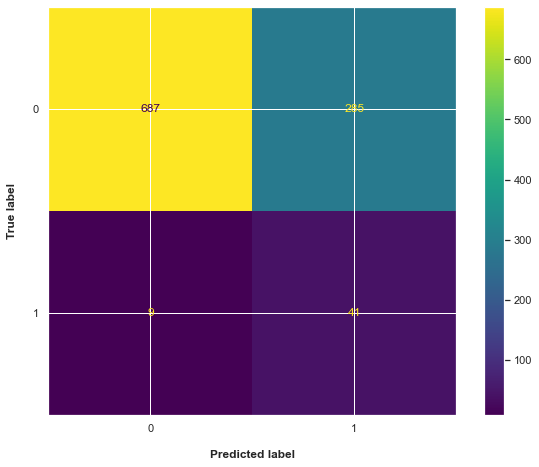

In [95]:
fig, ax = plt.subplots(figsize=(10,7.5))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax)
plt.xlabel("\nPredicted label", fontweight="bold")
plt.ylabel("True label\n", fontweight="bold")

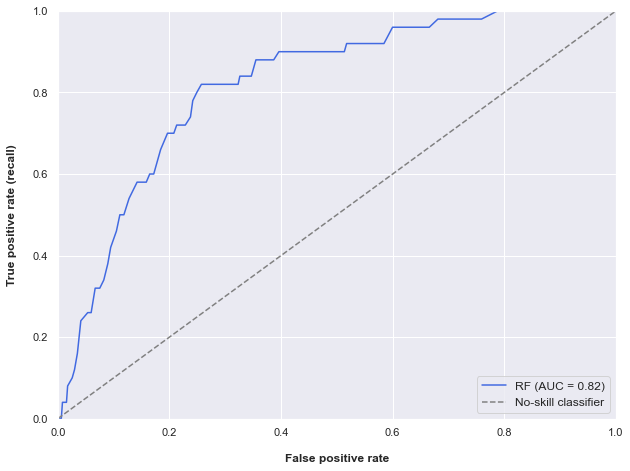

In [96]:
y_score = rf.predict_proba(X_test)[:, 1]
roc_auc = round(roc_auc_score(y_test, y_score), 3)
fpr, tpr, _ = roc_curve(y_test, y_score)

fig = plt.figure(figsize=(10,7.5))
plt.plot(
    fpr,
    tpr,
    color="royalblue",
    label=f"RF (AUC = {roc_auc})",
)
plt.plot(
    [0, 1], 
    [0, 1], 
    color="grey", 
    linestyle="--",
    label=f"No-skill classifier",
)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("\nFalse positive rate", fontweight="bold")
plt.ylabel("True positive rate (recall)\n", fontweight="bold")
plt.legend(loc="lower right", prop={"size": 12})
fig.show()